In [1]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Where the text files are going to live.
dataset_path = "corpus"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")


In [3]:
!dir

 Volume in drive E is DS
 Volume Serial Number is F04F-804B

 Directory of e:\Project\dsr32\12NLP_Transfer_Learning

10/28/2022  03:34 PM    <DIR>          .
10/28/2022  03:34 PM    <DIR>          ..
10/28/2022  03:34 PM             8,566 commands_gpu.ipynb
10/28/2022  03:41 PM    <DIR>          corpus
10/28/2022  12:09 PM    <DIR>          dataset
10/28/2022  02:19 PM           586,963 DSR Batch 32 IMDB.ipynb
10/26/2022  04:26 PM           244,999 DSR Batch 32.ipynb
10/28/2022  10:07 AM           513,061 DSR_Batch_32_Gensim.ipynb
10/28/2022  03:45 PM           111,122 DSR_Batch_32_Language_Generation.ipynb
10/28/2022  02:19 PM           213,373 DSR_Batch_32_LSTM.ipynb
10/28/2022  03:45 PM            24,707 language_generation.ipynb
               7 File(s)      1,702,791 bytes
               4 Dir(s)  426,746,421,248 bytes free


In [4]:
!dir /b corpus
print("")
!dir /b corpus\all
print("")
!dir /b corpus\train
print("")
!dir /b corpus\valid

all
train
valid

a_song_of_ice_and_fire_1.txt
a_song_of_ice_and_fire_2.txt
a_song_of_ice_and_fire_3.txt
a_song_of_ice_and_fire_4.txt
a_song_of_ice_and_fire_5.txt

a_song_of_ice_and_fire_1.txt
a_song_of_ice_and_fire_2.txt
a_song_of_ice_and_fire_3.txt

a_song_of_ice_and_fire_4.txt
a_song_of_ice_and_fire_5.txt


In [22]:
batch_size = 32
seed = 42

def create_dataset(dataset_path):
    dataset = preprocessing.text_dataset_from_directory(
        dataset_path,
        labels=None,
        batch_size=batch_size,
        seed=seed
    )

    return dataset


dataset_original_all = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 5 files belonging to 1 classes.
Found 3 files belonging to 1 classes.
Found 2 files belonging to 1 classes.


In [23]:
vocabulary_size = 30_000


encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize="lower",
    split="whitespace",
    output_mode="int"
)

encoder.adapt(dataset_original_all)


vocabulary = encoder.get_vocabulary()

print(vocabulary[:100])

['', '[UNK]', 'the', 'and', 'to', 'a', 'of', 'he', 'his', 'was', 'in', 'had', 'her', 'as', 'she', 'you', 'that', 'i', 'with', 'it', 'not', 'for', 'but', 'at', 'is', 'on', 'have', 'they', 'my', 'be', 'him', 'from', 'would', 'were', 'when', 'no', 'your', 'lord', 'will', 'all', 'their', 'if', 'one', 'so', 'ser', 'could', 'them', 'are', 'said', 'been', 'me', 'by', 'up', 'we', 'this', 'did', 'do', 'man', 'or', 'than', 'what', '“i', 'who', 'more', 'only', 'like', 'there', 'back', 'out', 'men', 'down', 'jon', 'some', 'him.', 'even', 'an', 'old', 'never', 'into', 'made', 'told', 'before', 'has', 'see', 'might', 'off', 'said.', 'tyrion', 'know', 'through', 'black', 'where', 'king', 'him,', 'long', '“the', 'said,', 'must', 'how', 'about']


In [24]:
sequence_length = 32

def create_dataset_for_autoregression(dataset):
      x_inputs = []
      y_outputs = []

      padding_token_id = vocabulary.index("") # 0

      for books in dataset:
            books = encoder(books).numpy()

            for book in tqdm(books):
                  # print(books)
                  padding = [padding_token_id]*sequence_length
                  book = padding +list(book)
                  # print(padding)

                  for start_index in range(0, len(book)-sequence_length):
                        x = book[start_index : start_index + sequence_length]
                        y = book[start_index + sequence_length]

                        # print(x)
                        # print(y)
                        # print("")
                        # if start_index == 34:
                        #       assert False
                        if y == padding_token_id:
                              break

                        x_inputs += [x]
                        y_outputs += [y]

      print("Finished")
      print(len(x_inputs), len(y_outputs))
      return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))

dataset_train = create_dataset_for_autoregression(dataset_original_train)


100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


Finished
931821 931821


In [25]:
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Finished
732679 732679


In [26]:
embedding_size = 128

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))
model.add(layers.LSTM(512))
model.add(layers.Dense(vocabulary_size, activation="softmax"))

model.summary()


model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.cache().shuffle(90_000).batch(512),
    validation_data=dataset_valid.cache().batch(512),
    epochs=3
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 128)           3840000   
                                                                 
 lstm_2 (LSTM)               (None, 512)               1312768   
                                                                 
 dense_2 (Dense)             (None, 30000)             15390000  
                                                                 
Total params: 20,542,768
Trainable params: 20,542,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1820/1820 [==============================] - 588s 322ms/step - loss: 6.6602 - accuracy: 0.0941 - val_loss: 6.3610 - val_accuracy: 0.1194
Epoch 2/3
1820/1820 [==============================] - 580s 319ms/step - loss: 5.7405 - accuracy: 0.1375 - val_loss: 6.0717 - val_accuracy: 0.1372
Epoch 3/3
18

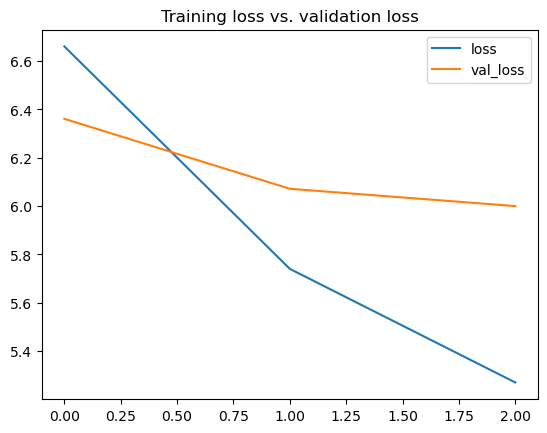

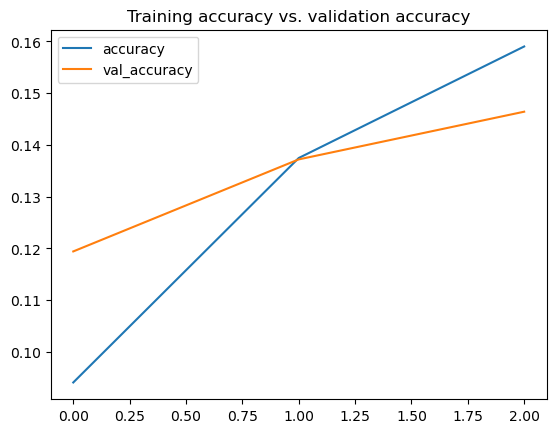

In [27]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

render_history(history)

In [28]:
import numpy as np
def decode(indices):
    return " ".join([vocabulary[index] for index in indices if vocabulary[index] != ""])
def generate(model, seed_text, generated_sequence_length, temperature):

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::])

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0))
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    print(text)
    print("")

        
def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)
  

generate(model, "we are all doomed", 100, temperature=1.0)

1/1 [==============================] - 0s 30ms/step
we are all doomed so far when he must. neither realized, she told me that she had tried to win, varys got at a good [UNK] he watched himself a few feet above her en, while he could ser [UNK] awaits.” wrenching him a few look, and ser wendel hung outlined side as they bent the pair of hell. the fight, whose piled flight of onions atop the gallery ran gone. the others blew out the shell of the [UNK] of house stark on their smile; a flock of blowing on the marble head. a flame was like nothing; [UNK]



In [14]:
generate(model, "I will kill you", 100, temperature=1.0)

1/1 [==============================] - 0s 30ms/step
i will kill you no one they want” [UNK] all jon why not” she glanced up across the room hunched on a arms of brown doors silver then theon knew this brother but he could not look on his own head and leaned too “how did he know” he moved to mount up off his head looked a red force out two of them “little longer ever stupid or he is called the steward die a chestnut man wanted his own strong right for tasks to match the child” he thought “how could there end you know no don’t that



In [15]:
generate(model, "yes my lord, why not", 100, temperature=1.0)

1/1 [==============================] - 0s 29ms/step
yes my lord why not you ever honest or everyone he’d ransomed you won’t [UNK] his mutton as well as i fancied myself but none you can be eating accusations but out to yield to the watch there are the steward when i receive over bran to guard out to me no more than human so he seems he was near [UNK] “as she gets her leave to save [UNK] joffrey will smell when they died over the secret of the narrow sea this [UNK] will the lannisters here the dear king had sent her maidenhead but she was ser



In [29]:
generate(model, "I will kill you", 50, temperature=1.0)

1/1 [==============================] - 0s 33ms/step
i will kill you with. i’m taken you.” “you was a fancy a boy, what need in truth, and your lords stark of highgarden. is him true than any enemies in day it soon be [UNK] like it. . . . the squires of heroes. yet caught a word. he



In [32]:
generate(model, "yes my lord, why not", 100, temperature=1.0)


1/1 [==============================] - 0s 27ms/step
yes my lord, why not not bend the realization in the attack, a brindled [UNK] but any man to settle every boys.” she smiled. “they heard here." thirty men holds the gates before, while steps, rivers will have been so one in the castle of the [UNK] square mouth announced. jon took their horn to silent shoulder. her arrows, no one lifts the corpse of [UNK] over. four women said nothing. harren the oaf, so morning, the defenses have gone from them questioned missing into the world. catelyn observed. ser jacelyn said. she was the hound. "you shall take you

